<a href="https://colab.research.google.com/github/Mohammad-Rahmdel/SIGNS_Recognition_Using_Tensorflow/blob/master/SIGNS_CNN_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!mkdir datasets 

download = drive.CreateFile({'id': '1fCmaeQyBWf9RFsaGdRYiAG-BypTzN8Nu'})
download.GetContentFile('datasets/test_signs.h5')

download = drive.CreateFile({'id': '1nU3KQ7fdTcfHNgY8jk9xbhqYlxDcWiiu'})
download.GetContentFile('datasets/train_signs.h5')

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

def load_dataset():
  
    train_dataset = h5py.File('./datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

Cost after epoch 0: 1.873255
Cost after epoch 5: 1.728289
Cost after epoch 10: 1.087133
Cost after epoch 15: 0.866747
Cost after epoch 20: 0.736680
Cost after epoch 25: 0.626305
Cost after epoch 30: 0.574208
Cost after epoch 35: 0.542627
Cost after epoch 40: 0.453274
Cost after epoch 45: 0.439011
Cost after epoch 50: 0.410424
Cost after epoch 55: 0.376274
Cost after epoch 60: 0.357062
Cost after epoch 65: 0.344419
Cost after epoch 70: 0.321533
Cost after epoch 75: 0.319679
Cost after epoch 80: 0.320514
Cost after epoch 85: 0.331128
Cost after epoch 90: 0.281599
Cost after epoch 95: 0.257652
Cost after epoch 100: 0.281862
Cost after epoch 105: 0.266236
Cost after epoch 110: 0.256997
Cost after epoch 115: 0.244683


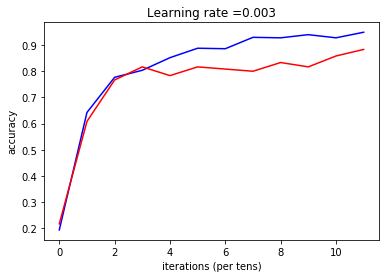

Train Accuracy: 0.91851854
Test Accuracy: 0.84166664


In [44]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops


np.random.seed(1)

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# # Example of a picture
# index = 21
# plt.imshow(X_train_orig[index])
# print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
# plt.show()



X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

conv_layers = {}





def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True, lambd=0.0, keep_prob=1):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train (None, 64, 64, 3)
    Y_train (None, n_y = 6)
    X_test  (None, 64, 64, 3)
    Y_test  (None, n_y = 6)

    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []  
    train_acc = []
    test_acc = []                                   


    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype=tf.float32, name = 'X')
    Y = tf.placeholder(shape=[None, n_y], dtype=tf.float32, name = 'Y')


    tf.set_random_seed(1)                        
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))


    s = 1
    Z1 = tf.nn.conv2d(X, W1, strides = [1,s,s,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    f = s = 8 # f = window size
    P1 = tf.nn.max_pool(A1, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')


    s = 1
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,s,s,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    f = s = 4
    P2 = tf.nn.max_pool(A2, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')

    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)

    # FULLY-CONNECTED without non-linear activation function (not call softmax).
    # 6 neurons in output layer. "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6, activation_fn=None)
    Z3 = tf.nn.dropout(Z3, keep_prob)

    """
    In the last function above (tf.contrib.layers.fully_connected), the fully connected layer automatically 
    initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need 
    to initialize those weights when initializing the parameters.
    """

 
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y) + lambd * tf.nn.l2_loss(W1) + lambd * tf.nn.l2_loss(W2)
    cost = tf.reduce_mean(cost)
    
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer() 
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
            
                minibatch_cost += temp_cost / num_minibatches



            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)


            if epoch % 10 == 0 :
                predict_op = tf.argmax(Z3, 1)
                correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
                
                # Calculate accuracy on the test set
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                train_acc.append(accuracy.eval({X: X_train, Y: Y_train}))
                test_acc.append(accuracy.eval({X: X_test, Y: Y_test}))
            
        _, ax = plt.subplots()
        ax.plot(np.squeeze(train_acc), '-b', label='train accuracy')
        ax.plot(np.squeeze(test_acc), '-r', label='test accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
             

        
        
        
        # # plot the cost
        # plt.plot(np.squeeze(costs))
        # plt.ylabel('cost')
        # plt.xlabel('iterations (per tens)')
        # plt.title("Learning rate =" + str(learning_rate))
        # plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

    
model(X_train, Y_train, X_test, Y_test, learning_rate = 0.003, num_epochs = 120, 
      minibatch_size = 32, print_cost = True, lambd = 0.001, keep_prob=0.9)
